In [76]:
import re
from typing import List
import string
from collections import Counter
import numpy as np
import pandas as pd
from read_data import read_data

import nltk
import install_nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [78]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guldenizbektas/nltk_data...


True

In [5]:
train, test = read_data()

/Users/guldenizbektas/Documents/turknet_final/read_data.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train = pd.read_sql_query("SELECT * FROM train;", conn)
/Users/guldenizbektas/Documents/turknet_final/read_data.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql_query("SELECT * FROM test;", conn)


In [8]:
train.shape

(6000, 2)

In [9]:
test.shape

(2000, 2)

In [10]:
train.head()

,category,text
0,ai,Because of their occasional need to return to ...
1,ai,Market price systems constitute a well-underst...
2,ai,We describe an extensive study of search in GS...
3,ai,As real logic programmers normally use cut (!)...
4,ai,To support the goal of allowing users to recor...


Our data is not shuffled. So they ordered like first 1500 entry is about ai, and the next 1500 is about ml and so on... We need to shuffle it.

In [13]:
# shuffle the datasets
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
train.head()

,category,text
0,ml,"Kernel density estimation, a.k.a. Parzen windo..."
1,cv,"In this paper, we propose a new approach that ..."
2,ai,This article introduces the idea that probabil...
3,ml,Cluster analysis has attracted more and more a...
4,ds,In this paper we consider two above lower boun...


`category` column is categorical and string. We can convert it to numeric labels with `sklearn.preprocessing.LabelEncoder`.

In [15]:
# target will be the numerical value of the class
labeler = LabelEncoder()
train["target"] = labeler.fit_transform(train["category"])
test["target"] = labeler.transform(test["category"])

Now we should understand numeric representations of categories.

In [16]:
# make ready for human readable results
mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
mapping

{'ai': 0, 'cv': 1, 'ds': 2, 'ml': 3}

This will help us transform model outputs and understand them.

We know our categories are balanced since I fetched them. But lets visualize them.

Text(0.5, 1.0, 'Test Set')

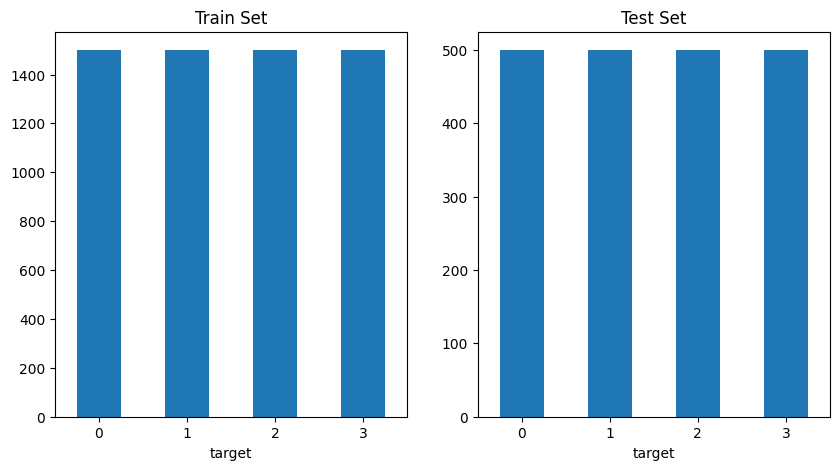

In [21]:
# number of samples
train_cnts = train.groupby("target").size()
test_cnts = test.groupby("target").size()

fig, (ax1, ax2 )= plt.subplots(1, 2, figsize=(10,5), sharex=True)
train_cnts.plot(kind='bar', ax=ax1, rot=0)
test_cnts.plot(kind='bar', ax=ax2, rot=0)
ax1.set_title("Train Set")
ax2.set_title("Test Set")

Take a look at class distributions.

Text(0, 0.5, '%')

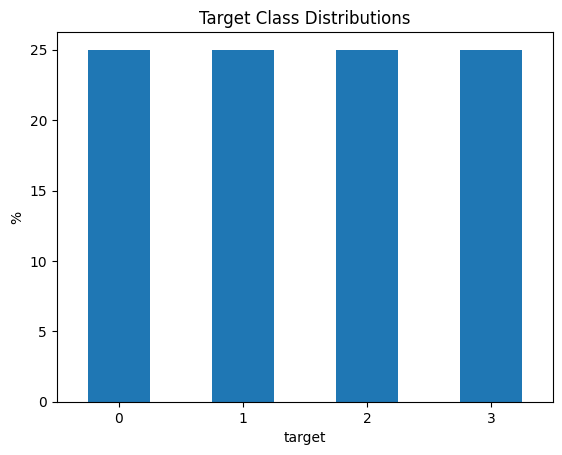

In [22]:
percents = 100 * train.groupby("target").size() / train.shape[0]

percents.plot(kind='bar', title='Target Class Distributions', rot=0)
plt.ylabel("%")

Our categories are greatly balanced.

With `wordcloud` let's see which words are in majority for each category.

In [23]:
def plot_wordcloud(df: pd.DataFrame, category: str, target: int) -> None:
    words = " ".join(df[df["target"] == target]["text"].values)

    plt.rcParams['figure.figsize'] = 10, 20
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                          background_color="white",
                          max_words=1000).generate(words)

    plt.title("WordCloud For {}".format(category))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

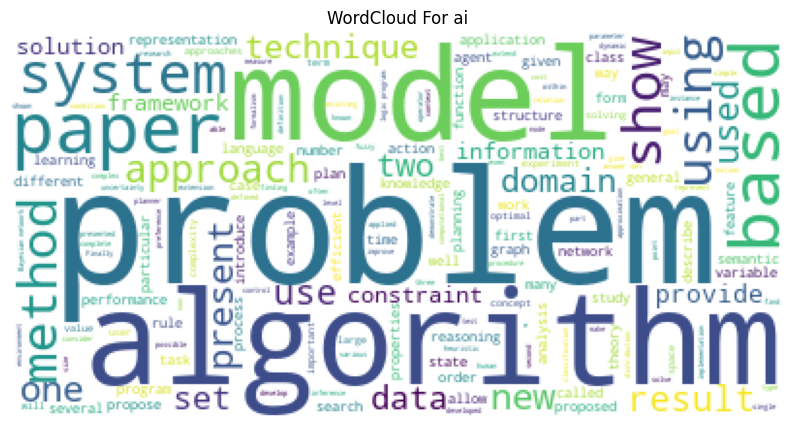

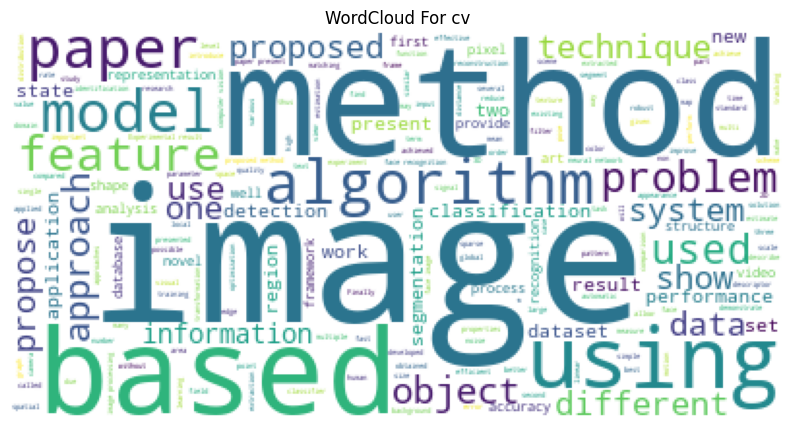

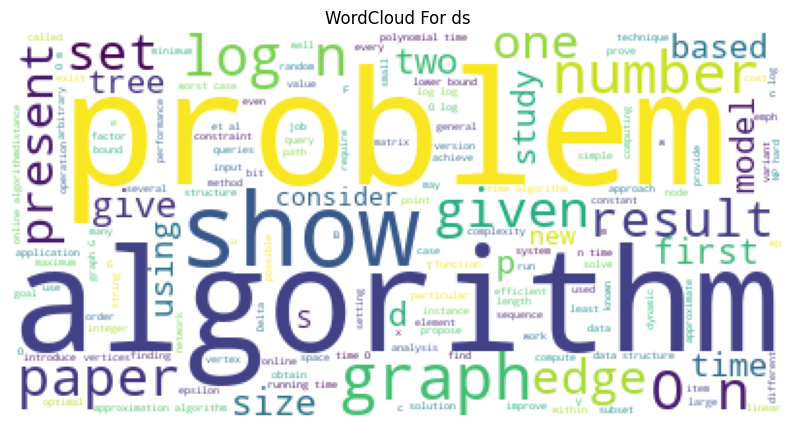

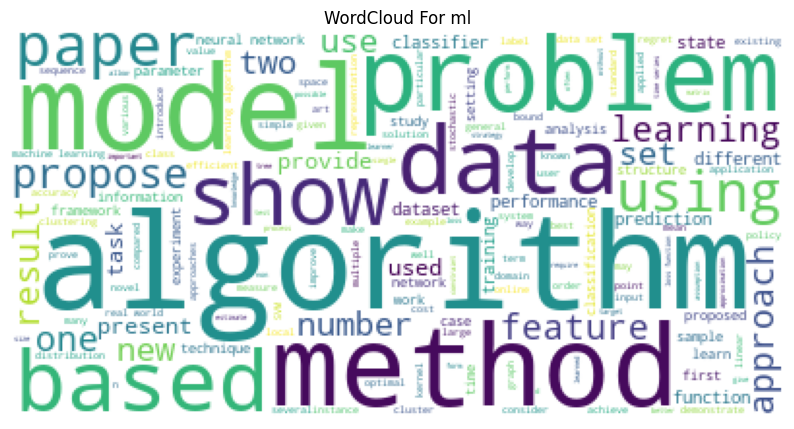

In [24]:
for category, target in mapping.items():
    plot_wordcloud(train, category, target)

Probably because of papers categories, each wordcloud has kinda same words. `problem` and `algorithm` are the ones that we can see really big at the center of each categories wordcloud. But left of the words are very specific.

Let's see this straight. Sometimes we can see punctuations and meaningless stopwords, so I'll remove them to see top 20 words for each category.

In [28]:
# remove stop words
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [29]:
def common_words_by_cat(df, cat, number):
    word_counts = Counter()
    for text in df[df["category"] == cat]["text"]:
        tokens = word_tokenize(text.lower())
        filtered_tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
        word_counts.update(filtered_tokens)
    top_20_words = word_counts.most_common(number)
    for word, count in top_20_words:
        print(word, count)

In [32]:
print("Most common words in ML:")
common_words_by_cat(train, "ml", 20)

print("\nMost common words in AI:")
common_words_by_cat(train, "ai", 20)

print("\nMost common words in CV:")
common_words_by_cat(train, "cv", 20)

print("\nMost common words in DS:")
common_words_by_cat(train, "ds", 20)

Most common words in ML:
learning 2033
data 1498
algorithm 1218
problem 858
algorithms 837
model 763
method 753
paper 737
show 731
methods 678
results 639
using 605
based 572
classification 561
proposed 554
performance 546
propose 542
approach 525
models 519
also 500

Most common words in AI:
paper 951
problem 772
algorithm 690
model 602
approach 595
problems 594
based 594
show 586
search 559
system 542
new 534
results 526
using 523
data 508
knowledge 457
set 454
algorithms 450
used 447
information 443
models 443

Most common words in CV:
image 2039
images 1358
method 1155
paper 966
proposed 923
based 894
recognition 876
using 862
algorithm 793
results 699
methods 642
approach 626
used 609
model 604
face 601
data 595
features 585
detection 553
problem 547
different 531

Most common words in DS:
algorithm 2290
problem 2244
n 1879
time 1703
algorithms 1102
graph 948
k 912
show 792
number 779
graphs 690
problems 673
set 670
approximation 638
paper 616
data 612
also 609
given 606
1 587
two

Again we can see word `algorithm` in each. Also `algorithm`. The rest are related words by each category. One thing is that in DS (Data Structures and Algorithms) you see k, n, 1. My guess is that DS topics usually contains this kinda reprentation letter for values. So seeing these letters is not that weird. 1 is also might be about dimensions. I bet there are 2 or 3 even. Let's see.

In [52]:
train[train.text.str.contains(" n ")].iloc[0]["text"]

'We consider the discrepancy problem of coloring $n$ intervals with $k$ colors\nsuch that at each point on the line, the maximal difference between the number\nof intervals of any two colors is minimal. Somewhat surprisingly, a coloring\nwith maximal difference at most one always exists. Furthermore, we give an\nalgorithm with running time $O(n \\log n + kn \\log k)$ for its construction.\nThis is in particular interesting because many known results for discrepancy\nproblems are non-constructive. This problem naturally models a load balancing\nscenario, where $n$ tasks with given start- and endtimes have to be distributed\namong $k$ servers. Our results imply that this can be done ideally balanced.\n  When generalizing to $d$-dimensional boxes (instead of intervals), a solution\nwith difference at most one is not always possible. We show that for any $d \\ge\n2$ and any $k \\ge 2$ it is NP-complete to decide if such a solution exists,\nwhich implies also NP-hardness of the respective m

In [66]:
train[train.text.str.contains(" n ")].iloc[54]["text"]

'We investigate the problem of succinctly representing an arbitrary\npermutation, \\pi, on {0,...,n-1} so that \\pi^k(i) can be computed quickly for\nany i and any (positive or negative) integer power k. A representation taking\n(1+\\epsilon) n lg n + O(1) bits suffices to compute arbitrary powers in\nconstant time, for any positive constant \\epsilon <= 1. A representation taking\nthe optimal \\ceil{\\lg n!} + o(n) bits can be used to compute arbitrary powers\nin O(lg n / lg lg n) time.\n  We then consider the more general problem of succinctly representing an\narbitrary function, f: [n] \\rightarrow [n] so that f^k(i) can be computed\nquickly for any i and any integer power k. We give a representation that takes\n(1+\\epsilon) n lg n + O(1) bits, for any positive constant \\epsilon <= 1, and\ncomputes arbitrary positive powers in constant time. It can also be used to\ncompute f^k(i), for any negative integer k, in optimal O(1+|f^k(i)|) time.\n  We place emphasis on the redundancy, or

In [67]:
train[train.text.str.contains(" n ")].iloc[10]["text"]

'This paper describes a graph clustering algorithm that aims to minimize the\nnormalized cut criterion and has a model order selection procedure. The\nperformance of the proposed algorithm is comparable to spectral approaches in\nterms of minimizing normalized cut. However, unlike spectral approaches, the\nproposed algorithm scales to graphs with millions of nodes and edges. The\nalgorithm consists of three components that are processed sequentially: a\ngreedy agglomerative hierarchical clustering procedure, model order selection,\nand a local refinement.\n  For a graph of n nodes and O(n) edges, the computational complexity of the\nalgorithm is O(n log^2 n), a major improvement over the O(n^3) complexity of\nspectral methods. Experiments are performed on real and synthetic networks to\ndemonstrate the scalability of the proposed approach, the effectiveness of the\nmodel order selection procedure, and the performance of the proposed algorithm\nin terms of minimizing the normalized cut 

In [68]:
train[train.text.str.contains(" k ")].iloc[34]["text"]

'We obtain upper and lower bounds for running times of exponential time\nalgorithms for the detection of weak backdoor sets of 3CNF formulas,\nconsidering various base classes. These results include (omitting polynomial\nfactors), (i) a 4.54^k algorithm to detect whether there is a weak backdoor set\nof at most k variables into the class of Horn formulas; (ii) a 2.27^k algorithm\nto detect whether there is a weak backdoor set of at most k variables into the\nclass of Krom formulas. These bounds improve an earlier known bound of 6^k. We\nalso prove a 2^k lower bound for these problems, subject to the Strong\nExponential Time Hypothesis.'

`\n`'s are representing new line so ignore them but you can see `(n \\log n + kn \\log k)`. `n` are part of mathematical equations. So seeing n in top 20 is normal thinking the abstracts can likely have these kind of representations.

So my idea is to keep those letters. It can help our model to find relations for specific category. There are digits too. Let's check what they represent

In [58]:
train[train.text.str.contains(" 2 ")].iloc[0]["text"]

'We consider several combinatorial optimization problems which combine the\nclassic shop scheduling problems, namely open shop scheduling or job shop\nscheduling, and the shortest path problem. The objective of the obtained\nproblem is to select a subset of jobs that forms a feasible solution of the\nshortest path problem, and to execute the selected jobs on the open (or job)\nshop machines to minimize the makespan. We show that these problems are NP-hard\neven if the number of machines is two, and cannot be approximated within a\nfactor less than 2 if the number of machines is an input unless P=NP. We\npresent several approximation algorithms for these combination problems.'

In [59]:
train[train.text.str.contains(" 2 ")].iloc[10]["text"]

"Concept drift refers to a non stationary learning problem over time. The\ntraining and the application data often mismatch in real life problems. In this\nreport we present a context of concept drift problem 1. We focus on the issues\nrelevant to adaptive training set formation. We present the framework and\nterminology, and formulate a global picture of concept drift learners design.\nWe start with formalizing the framework for the concept drifting data in\nSection 1. In Section 2 we discuss the adaptivity mechanisms of the concept\ndrift learners. In Section 3 we overview the principle mechanisms of concept\ndrift learners. In this chapter we give a general picture of the available\nalgorithms and categorize them based on their properties. Section 5 discusses\nthe related research fields and Section 5 groups and presents major concept\ndrift applications. This report is intended to give a bird's view of concept\ndrift research field, provide a context of the research and position it

In here `Section 2` it's been used to point out section. So we cannot say it's something that we might need but in the first example, it means something:

`...factor less than 2...`

But simply removing the numbers used for purposes such as specifying a section from the text means that we lose the numbers that indicate a topic related to the usage.

In [60]:
train[train.text.str.contains(" 2 ")].iloc[20]["text"]

'We give a nearly optimal sublinear-time algorithm for approximating the size\nof a minimum vertex cover in a graph G. The algorithm may query the degree\ndeg(v) of any vertex v of its choice, and for each 1 <= i <= deg(v), it may ask\nfor the i-th neighbor of v. Letting VC_opt(G) denote the minimum size of vertex\ncover in G, the algorithm outputs, with high constant success probability, an\nestimate VC_estimate(G) such that VC_opt(G) <= VC_estimate(G) <= 2 * VC_opt(G)\n+ epsilon*n, where epsilon is a given additive approximation parameter. We\nrefer to such an estimate as a (2,epsilon)-estimate. The query complexity and\nrunning time of the algorithm are ~O(avg_deg * poly(1/epsilon)), where avg_deg\ndenotes the average vertex degree in the graph. The best previously known\nsublinear algorithm, of Yoshida et al. (STOC 2009), has query complexity and\nrunning time O(d^4/epsilon^2), where d is the maximum degree in the graph.\nGiven the lower bound of Omega(avg_deg) (for constant epsilo

In [61]:
train[train.text.str.contains(" 2 ")].iloc[25]["text"]

'In the SCHED problem we are given a set of n jobs, together with their\nprocessing times and precedence constraints. The task is to order the jobs so\nthat their total completion time is minimized. SCHED is a special case of the\nTraveling Repairman Problem with precedences. A natural dynamic programming\nalgorithm solves both these problems in 2^n n^O(1) time, and whether there\nexists an algorithms solving SCHED in O(c^n) time for some constant c < 2 was\nan open problem posted in 2004 by Woeginger. In this paper we answer this\nquestion positively.'

In order not to lose such meanings, it would be much healthier to keep the numbers in the text. we should not lose the meanings that can lead us to the category. But we can convert them to their text representations. Like 2 -> two.

Abstracts can be long texts. So let's look at the number of tokens contained in each abstract by category.

<Axes: xlabel='num_tokens', ylabel='Count'>

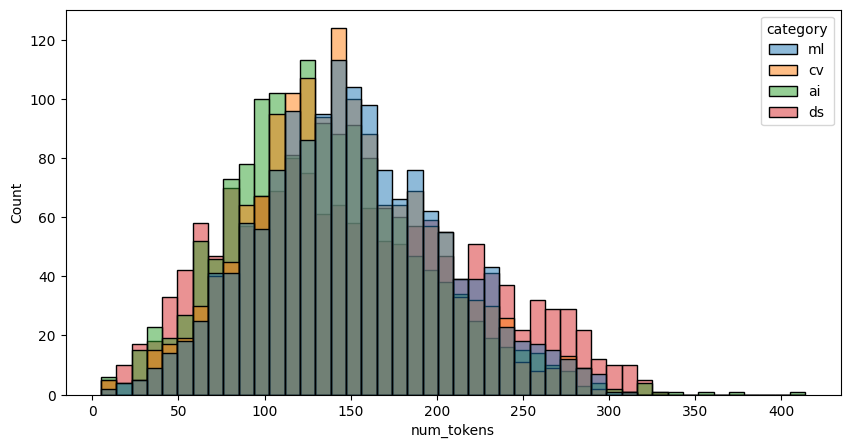

In [63]:
plt.figure(figsize=(10,5))
train_df = train.assign(num_tokens=train.text.str.split().apply(len))

sns.histplot(data=train_df, x="num_tokens", hue="category")

<Axes: xlabel='num_tokens', ylabel='Count'>

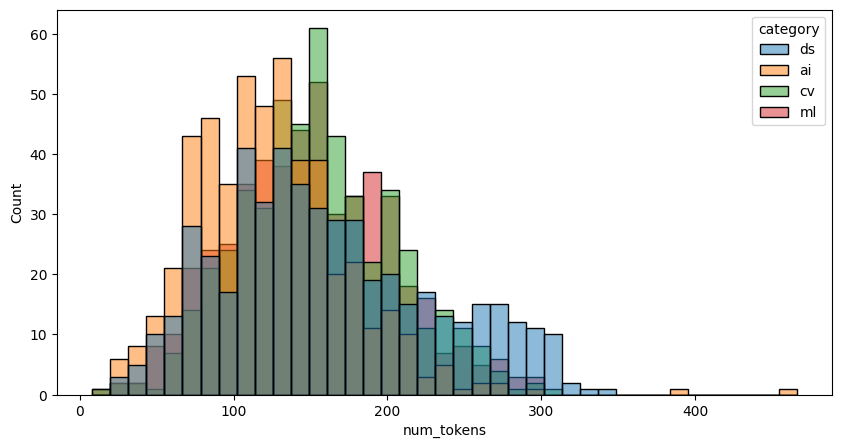

In [64]:
plt.figure(figsize=(10,5))
test_df = test.assign(num_tokens=test.text.str.split().apply(len))

sns.histplot(data=test_df, x="num_tokens", hue="category")

There is a distribution around 150. Our data is normally distributed. We can see abstracts containing less or more than 400 tokens in train and test. there is an estimated 500 samples in the test set. Our data doesn't have huge outliers, I'm relieved.

While the token distribution in train is almost the same for each category, in the test set the AI category seems to be showing off in token maintenance.

In [71]:
train[train.text.str.contains("https")].iloc[3]["text"]

'In recent years, quadratic weighted kappa has been growing in popularity in\nthe machine learning community as an evaluation metric in domains where the\ntarget labels to be predicted are drawn from integer ratings, usually obtained\nfrom human experts. For example, it was the metric of choice in several recent,\nhigh profile machine learning contests hosted on Kaggle :\nhttps://www.kaggle.com/c/asap-aes , https://www.kaggle.com/c/asap-sas ,\nhttps://www.kaggle.com/c/diabetic-retinopathy-detection . Yet, little is\nunderstood about the nature of this metric, its underlying mathematical\nproperties, where it fits among other common evaluation metrics such as mean\nsquared error (MSE) and correlation, or if it can be optimized analytically,\nand if so, how. Much of this is due to the cumbersome way that this metric is\ncommonly defined. In this paper we first derive an equivalent but much simpler,\nand more useful, definition for quadratic weighted kappa, and then employ this\nalternate

I thought abstracts wouldn't have website links in it. I decided to look to be safe than sorry. And I was right. There are not a lot but we should get rid of them. We'll do that in another notebook.

Also abstracts are more likely to contain latin characters for some equations or any other representations. While creating a API, these are causing errors. In a way we should remove them from our texts. 

As for what we might need for our model, such representations are still on the math side, but they may not suggest as much logic in terms of operations as numbers or letters. Of course, we cannot say that they are absolutely useless, but we have to remove them for future problems.

In [85]:
train.iloc[63]["text"]

'In this paper, we study the two choice balls and bins process when balls are\nnot allowed to choose any two random bins, but only bins that are connected by\nan edge in an underlying graph. We show that for $n$ balls and $n$ bins, if the\ngraph is almost regular with degree $n^\\epsilon$, where $\\epsilon$ is not too\nsmall, the previous bounds on the maximum load continue to hold. Precisely, the\nmaximum load is $\\log \\log n + O(1/\\epsilon) + O(1)$. For general\n$\\Delta$-regular graphs, we show that the maximum load is $\\log\\log n +\nO(\\frac{\\log n}{\\log (\\Delta/\\log^4 n)}) + O(1)$ and also provide an almost\nmatching lower bound of $\\log \\log n + \\frac{\\log n}{\\log (\\Delta \\log n)}$.\n  V{\\"o}cking [Voc99] showed that the maximum bin size with $d$ choice load\nbalancing can be further improved to $O(\\log\\log n /d)$ by breaking ties to the\nleft. This requires $d$ random bin choices. We show that such bounds can be\nachieved by making only two random accesses and